本笔记本对应知乎问题 [蜜蜂在蜂巢随机游走一百步后离原点的距离期望是多少?](https://www.zhihu.com/question/266611177)

In [1]:
import numpy as np

In [2]:
A168605 =[1,2,8,30,104,342,1088,3390,10424,31782,96368,
 291150,877544,2640822,7938848,23849310,71613464,
 214971462,645176528,1936053870,5809210184,
 17429727702,52293377408,156888520830,470682339704,
 1412080573542]

A168605 = np.array(A168605)

In [246]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            23G        8.4G         14G         22M        415M         14G
Swap:           46G         18G         28G


In [236]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            23G        8.4G         14G         23M        379M         14G
Swap:           46G         18G         28G


In [2]:
###### 格点距离的精确精确解
N = 200
# arr = np.zeros((N//2,N),dtype ='float32')
arr = np.zeros((N//2,N),dtype =int)
arr[0,N//2]=1
# print arr
for i in range(1,N//2):
    last = arr[i-1,:]
    fir = [1]*3
    arr[i,:] = np.convolve(last,fir,mode='same')
#     arr[i,:] = arr[i,:]/arr[i,:].sum() ###可以考虑归一化防止underflow
    

x = abs(np.arange(0,N) - N//2)[None,:] ### grid x
# print arr[0,np.where(x == 0)[1]]
SUM = np.sum(x*arr,axis = 1)
print ','.join(str(x) for x in SUM.tolist()[:20])


0,2,8,30,104,350,1152,3738,12000,38214,120920,380666,1193304,3727490,11608352,36057510,111747744,345636486,1067179320,3289843578


In [404]:
%%time
#### 仿射坐标系上的蒙特卡罗采样
#### deg = 120
import numpy as np
import matplotlib.pyplot as plt

if 'tvec' in locals():
    del tvec ##清理内存
    
### 小心内存溢出
sample_size = int(10E5)
# sample_size = int(3E6)
batch_num = 1 ###确保能整除
T = 151
t = 100
delta = np.array([(0,1),(1,-1),(1,0),(0,-1),(-1,1),(-1,0),(0,0)])

lst = []
for i in range(batch_num):
    if 'Tvec' in locals():
        del Tvec,dvec ##清理内存
    start = np.ones((sample_size//batch_num,1),dtype = int) * -1
    idx = np.random.choice(6,size=(sample_size//batch_num,T))
    idx = np.concatenate([start,idx],axis = 1)
    dvec = delta[idx]
    Tvec = np.cumsum(dvec,axis = 1)
    if batch_num==1:
        break
#         return Tvec
    tvec = Tvec[:,t]
    lst += [tvec]
if lst:
    tvec = np.concatenate(lst,axis = 0,)
del lst

CPU times: user 4.95 s, sys: 2.08 s, total: 7.04 s
Wall time: 7.16 s


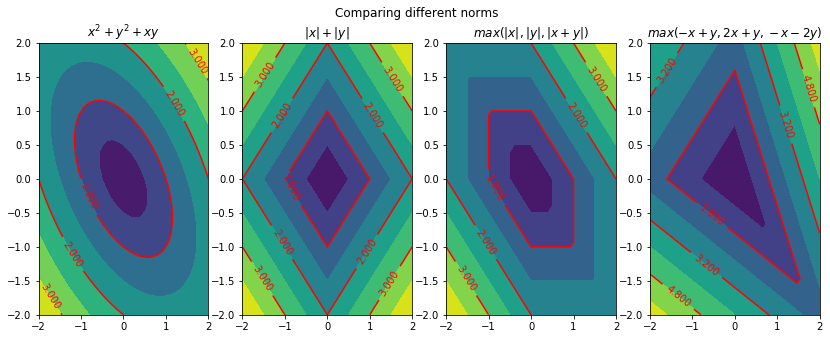

In [475]:
def dmet_2d(f,bins = 10,span=[-2,2],N = 1000):
    origin = 'lower'
    Nx = int(np.sqrt(N))
    Ny = Nx
    X = np.linspace(*(span+[Nx]))
    Y = np.linspace(*(span+[Ny]))
    Xs,Ys = np.meshgrid(X,Y)
    Zs = f(Xs,Ys)
    CS = plt.contourf(X,Y,Zs)
    CS2 = plt.contour(CS, levels=CS.levels[::2],
                  colors='r',
#                   origin=origin
                     )
#     Cs = plt.contour(X,Y,Zs)
    plt.clabel(CS2, inline=1, fontsize=10)
    return plt.gcf()

euc_dist = lambda x,y:np.sqrt(np.square([x,y]).sum(axis = 0)+x*y)
grid_dist0 = lambda x,y: np.minimum(abs(x),abs(y))
grid_dist1 = lambda x,y: np.maximum(abs(x),abs(y))
grid_dist2 = lambda x,y: np.maximum(np.maximum(abs(x),abs(y)),abs(x+y))
tri_dist = lambda x,y: np.maximum(np.maximum(-x+y,(2*x+y)),-x-2*y)
l1_dist = lambda x,y: abs(x) + abs(y)

grid_dist = grid_dist2
# grid_dist2 = lambda x,y: (abs(x+y))

# dmet_2d(euc_dist)
# plt.show()
# dmet_2d(grid_dist0)
# plt.show()
eqns = {
    euc_dist:'x^2+y^2+xy',
    l1_dist:'|x|+|y|',
    grid_dist:'max(|x|,|y|,|x+y|)',
    tri_dist:'max(-x+y,2x+y,-x-2y)',
}

metrics = ['euc_dist','l1_dist','grid_dist','tri_dist']

plt.figure(figsize = [14,5])
L = len(metrics)
for i,m  in enumerate(metrics):
    m = eval(m)
    plt.subplot(1,L,i+1)
    dmet_2d(m)
    tl = '$%s$'%(eqns[m])
    plt.title(tl)
plt.suptitle('Comparing different norms')
plt.show()

In [477]:
%%time
x = Tvec.take(0,axis = 2)
y = Tvec.take(1,axis = 2)
lst = []
for i,m  in enumerate(metrics):
    m = eval(m)
    d = m(x,y).mean(axis = 0)
    lst += [d];
Ds = lst[:]

CPU times: user 8.69 s, sys: 5.58 s, total: 14.3 s
Wall time: 14.3 s


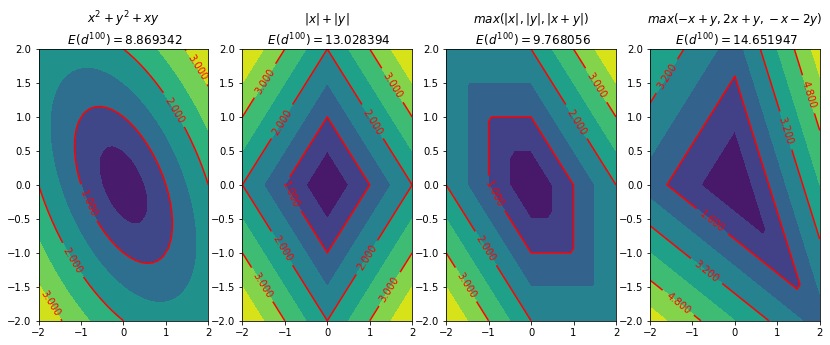

In [478]:
### De facto
plt.figure(figsize = [14,5])
L = len(metrics)
lst = []
for i,m  in enumerate(metrics):
    m = eval(m)
    plt.subplot(1,L,i+1)
    dmet_2d(m)
    tl = '$%s$'%(eqns[m])
    tl += '\n $E(d^{100})=%.6f$' % Ds[i][100]
    plt.title(tl)
plt.show()

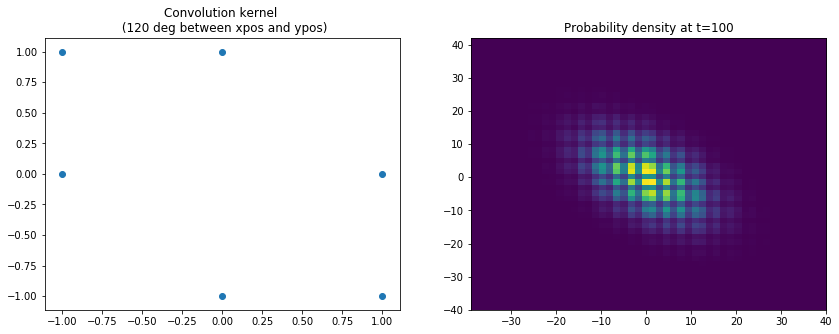

In [439]:
plt.figure(figsize= [14,5])
plt.subplot(121)
plt.scatter(delta[:-1,0],delta[:-1,1])
plt.title('Convolution kernel \n (120 deg between xpos and ypos)')

plt.subplot(122)
t = 100
plt.hist2d(x[:,t],y[:,t],50);
plt.title('Probability density at t=%d'%t)
plt.show()


In [272]:
y = d_e_mean**2
# y = d_e_sq_mean
coef = np.polyfit(ts,y,1)
print coef
# plt.plot(ts,y)
plt.show()


# y = d_e_mean**2
y = d_e_sq_mean
coef = np.polyfit(ts,y,1)
print coef
# plt.plot(ts,y)
plt.show()


[1.18239757 0.14493924]
[1.66264351 0.08989363]


In [243]:
%%time
d_m = abs(Tvec).sum(axis = 2)
d_m_Var = (d_m).var(axis=0)
d_m_sq_mean = np.square(d_m).mean(axis=0)
d_m_mean = (d_m).mean(axis=0)
ts = np.arange(len(d_m_Var))

CPU times: user 3.72 s, sys: 3.25 s, total: 6.97 s
Wall time: 6.98 s


In [282]:
%%time
d_m = np.maximum(abs(Tvec).max(axis = 2),abs(Tvec.sum(axis=2)))
d_m_Var = (d_m).var(axis=0)
d_m_sq_mean = np.square(d_m).mean(axis=0)
d_m_mean = (d_m).mean(axis=0)
ts = np.arange(len(d_m_Var))
print d_m_mean[100]

CPU times: user 4.78 s, sys: 2.67 s, total: 7.46 s
Wall time: 7.46 s


In [254]:
%%time
xs = Tvec[:,:,0]
ys = Tvec[:,:,1]
d_e = np.sqrt(xs**2+ys**2+xs*ys)
d_e_Var = (d_e).var(axis=0)
d_e_sq_mean = np.square(d_e).mean(axis=0)
d_e_mean = (d_e).mean(axis=0)
ts = np.arange(len(d_e_Var))

CPU times: user 3.49 s, sys: 9.06 s, total: 12.5 s
Wall time: 13.6 s


In [ ]:
def histo_t(t,tvec = None,Tvec = None,):
    if tvec is None:
        tvec = Tvec[:,t]
    sample_size = len(tvec)
    bins = np.arange(t)
    stl = "t=%d , N=%E"%(t,sample_size)
    print stl
    plt.figure(figsize = [12,6])
    plt.subplot(121)
    hex_dist = np.sum(abs(tvec),axis = 1)
    plt.hist(hex_dist,bins = bins)
    plt.xlim(0,t)
    plt.title("Manhattan distance histogram")
    stat = "E(d_m)=%f,\n Var(d_m)=%f"%(hex_dist.mean(),hex_dist.var())
    plt.xlabel('Manhattan distance at t = %d\n'%t+stat)
    # plt.show()
    # print "E(d_m)=",hex_dist.mean()


t=100 , N=1.000000E+06


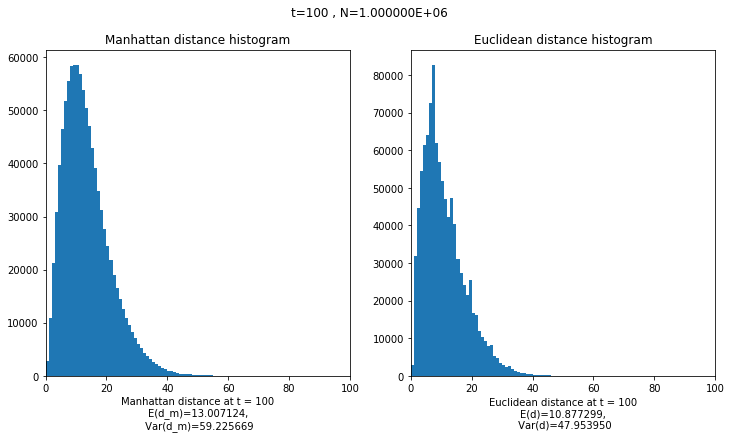

In [291]:
#### 数据可视化
### Not very good 
# t = 100

# def histo_t(t,sample_size = sample_size,Tvec = Tvec):
def histo_t(t,tvec = None,Tvec = None,):
    if tvec is None:
        tvec = Tvec[:,t]
    sample_size = len(tvec)
    bins = np.arange(t)
    stl = "t=%d , N=%E"%(t,sample_size)
    print stl
    plt.figure(figsize = [12,6])
    plt.subplot(121)
    hex_dist = np.sum(abs(tvec),axis = 1)
    plt.hist(hex_dist,bins = bins)
    plt.xlim(0,t)
    plt.title("Manhattan distance histogram")
    stat = "E(d_m)=%f,\n Var(d_m)=%f"%(hex_dist.mean(),hex_dist.var())
    plt.xlabel('Manhattan distance at t = %d\n'%t+stat)
    # plt.show()
    # print "E(d_m)=",hex_dist.mean()

    plt.subplot(122)

    euc_dist = np.sqrt(np.sum(tvec**2,axis = 1) + tvec[:,0]*tvec[:,1])
    plt.hist(euc_dist,bins = bins)
    plt.xlim(0,t)
    plt.title("Euclidean distance histogram")
    stat = "E(d)=%f,\n Var(d)=%f"%(euc_dist.mean(),euc_dist.var())

    plt.xlabel('Euclidean distance at t = %d\n'%t+stat)

    plt.suptitle(stl)
    plt.show()
    return plt.gcf()
t = 100
# tvec=  Tvec[:,t]
histo_t(t,Tvec = Tvec);

In [373]:
x = Tvec.take(0,axis = 2)
y = Tvec.take(1,axis = 2)
d_g = grid_dist(x,y)
# = Tvec.take(axis = 2,0)

In [374]:
d_g_mean = d_g.mean(axis = 0)
d_g_var = d_g.var(axis = 0)
d_g_sq = np.square(d_g)
d_g_msq = d_g_sq.mean(axis = 0)
print d_g_mean[100]

9.760201


In [177]:
d_m.shape

(500000, 152)

In [217]:

ts = np.arange(len(d_m_Var))
plt.plot(np.sqrt(d_m_sq_mean-d_m_Var))
coef = np.polyfit(ts,d_m_sq_mean,1)
print coef
coef[0] = coef[0] - 4./3
print coef
# plt.vlines(100,0,16)

# ?plt.vlines
# plt.show()

[ 2.28711816 -0.20202638]
[ 0.95378483 -0.20202638]


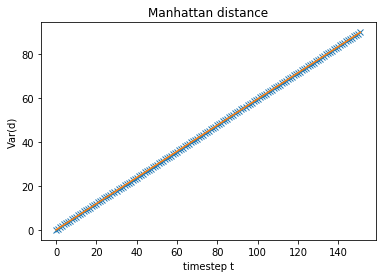

[ 0.5973319  -0.09968449]
2.7663511570364863
[1.47200286 0.19936898]


In [179]:
dist_name = 'Manhattan distance'
plt.plot(d_m_Var,'x')
plt.title(dist_name)
plt.ylabel('Var(d)')
plt.xlabel('timestep t')
# np.corrcoef()
ts = np.arange(len(d_m_Var))
z = np.polyfit(ts, d_m_Var, 1)
# print np.corrcoef([ts,d_m_Var])
plt.plot(ts,ts*z[0] + z[1])
plt.show()

# print z
# print 1/z[1]-np.pi
print z
print (8/3. - z[1])
z = -2*z
z[0]= z[0]+8/3.
print z 

$$
\begin{aligned}
E({d^t_{l1}}^2)=E(x_t^2+y_t^2 + 2|x_t | | y_t|) = \frac{4t}{3} + 2E(|x_t|)^2 
\\ = \frac{4t}{3} + \frac{2E(d^t_{l1})^2}{4} \\
E(d^t_{l1})^2 + Var(d^t_{l1}) =  \frac{4t}{3} + \frac{E(d^t_{l1})^2}{2} \\
E(d^t_{l1}) = \sqrt{\frac{8t}{3}-2Var(d^t_{l1})} 
\end{aligned}
$$

In [160]:
??np.polyfit

[1.36424969 0.0255188 ]


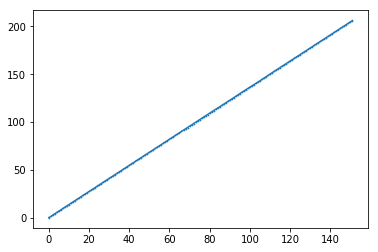

In [286]:
y = d_m_Var + d_m_mean**2/2
plt.plot(ts,y)
trunc = 0
ts =  ts[trunc:]
y = y[trunc:]
coef = np.polyfit(ts,y,1)
print coef
plt.scatter(ts,np.poly1d(coef)(ts),.5)
plt.show()
# print coef[0]*3


In [372]:
d_g_mean.shape

(152, 1)

[ 0.95316913 -0.01959799]


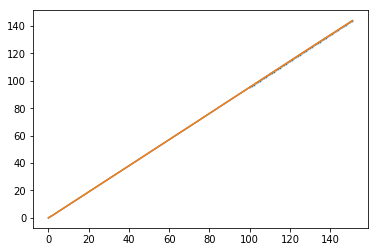

E(d^t_{l1})^2 = 0.9532 t + -0.0196
E(d^{100}_{l1}) = 9.762034
2.859507380326356


In [375]:
# y = d_m_mean**2
y = d_g_mean**2
t = ts[:]
plt.plot(t,y)
trunc = 100
t =  t[trunc:]
y = y[trunc:]
coef = np.polyfit(t,y,1)
print coef
f = np.poly1d(coef)

plt.scatter(t,f(t),.5)
plt.show()

print '%s = %.4f t + %.4f' %('E(d^t_{l1})^2',coef[0],coef[1])
print '%s = %.6f' %('E(d^{100}_{l1})',f(100)**0.5)
print coef[0]*3

In [104]:
print z
f=np.poly1d(z)
f(100)**0.5

[ 1.48008615 -1.15343866]


12.118381758270038

In [423]:
#### 一个不太成熟的近似

def ms():

    a, b, c, d, n = 0, 1, 1, -1, 1

    #yield 1

    while True:

        if 1:
            yield -b + (-1)**n*d
        n += 1

        a, b = b, (3*(n-1)*n*a+(2*n-1)*n*b)/((n+1)*(n-1))

        c, d = d, (3*(n-1)*c-(2*n-1)*d)/n
#         if n >=0:

A005043 = ms()

print([A005043.next() for _ in range(32)])

A005043 = ms()
lst = []
b = 1
for i in range(100):
    y = 3.**(i+1) /2. / b
#     print y
    a = A005043.next()
    b = 3*b-2*a
    
#     print (3.**i)
#    print x/3.**i
#    y = 3/2. * 1 / (1+x/3.**i)
#     print a,b

[0, 1, 1, 3, 6, 15, 36, 91, 232, 603, 1585, 4213, 11298, 30537, 83097, 227475, 625992, 1730787, 4805595, 13393689, 37458330, 105089229, 295673994, 834086421, 2358641376, 6684761125, 18985057351, 54022715451, 154000562758, 439742222071, 1257643249140, 3602118427251]
